In [1]:
# Установка метрик torch
!pip install -q torchmetrics   

In [2]:
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "FutureWarning")
plt.style.use("dark_background")

# дополнительные импорты для задачи

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm

C:\PROG\Anaconda\envs\Pytorch_1\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\drug1\AppData\Local\Temp\ipykernel_20956\1737343416.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Функция красивого вывода точек
# https://stackoverflow.com/questions/39719308/keras-model-creates-linear-classification-for-make-moons-data
def plot_decision_boundary(model: nn.Module) -> None:
    # установим минимальные и максимальные значения и добавим паддинг (отступы)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.1
    # сгенерируем сетку точек, с расстоянием h между ними
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # предскажем
    model.eval() # переводим модель в режим инференса
    with torch.no_grad(): # градиент не считаем
      data = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32)
      probs = torch.sigmoid(model(data).reshape(xx.shape))
      probs = probs.numpy().reshape(xx.shape)

    # отрисуем точки
    plt.figure(figsize=(15, 6))
    plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X[100:, 0], X[100:, 1],
                c=y[100:],
                cmap="RdBu",
                s=50,
                linewidth=1,
                alpha=.42,
                ec="black")
    plt.title("Decision Boundary")
    plt.axis("off")
    plt.show()


In [4]:
# ПРОВЕРКА GPU
!nvidia-smi

Tue Sep  5 15:08:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   60C    P8              22W / 170W |    341MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
torch.cuda.memory_summary(device=None, abbreviated=False)   # распределении памяти в графическом процессоре

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [6]:
# устанавливаем device если gpu или cpu
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Генерируем данные 
X, y = make_moons(n_samples = 6000, random_state=42, noise=.15)

In [8]:
print("counter", Counter(y))
print("type", type(y))

counter Counter({0: 3000, 1: 3000})
type <class 'numpy.ndarray'>


In [9]:
X

array([[-0.68899635,  1.15925621],
       [ 0.56373672, -0.57954332],
       [ 0.66358872, -0.06293931],
       ...,
       [ 1.55349186, -0.34079728],
       [ 1.77738381, -0.13639106],
       [ 0.57205882,  0.89724366]])

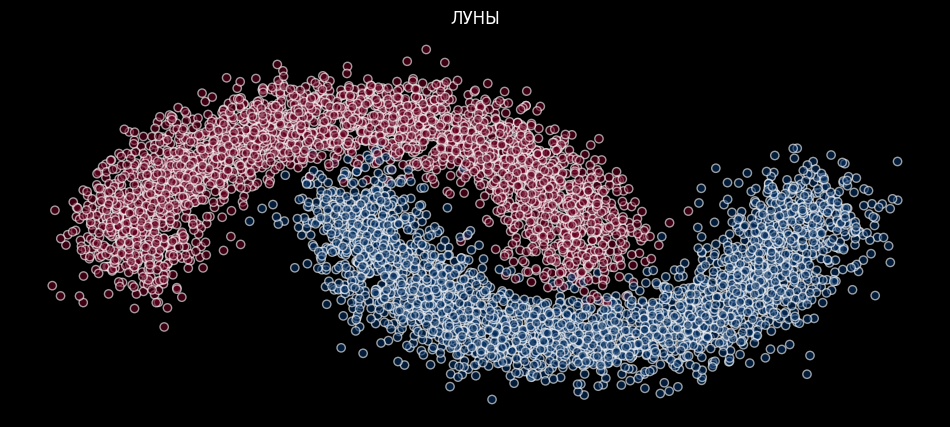

In [10]:
plt.figure(figsize=(12, 5))
plt.title("ЛУНЫ")
plt.scatter(X[:, 0], X[:, 1],
            c=y,
            cmap="RdBu",
            alpha=.6,
            ec="white"
            )
plt.axis("off")
plt.show()

## Загрузка датасета

In [11]:
# Разделяем данные на тренировочную и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [12]:
# Переводим данные с numpy в тензоры torch
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).type_as(train_X)
val_X = torch.from_numpy(X_val).to(torch.float32)
val_y = torch.from_numpy(y_val).type_as(val_X)

## Подготовка данных

In [13]:
BATCH = 64
# создали датасеты
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
# создаем загрузчики
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

## Полносвязная сеть

In [25]:
# Класс модели сети
class NNsuper(nn.Module):
  
  def __init__(self, in_features, out_features):
    super().__init__() 
    self.lin_linear_1 = self.make_layer(in_features, in_features * 8)
    self.lin_linear_2 = self.make_layer(in_features * 8, in_features * 4)
    self.lin_linear_3 = self.make_layer(in_features * 4, in_features * 2)
    self.lin_linear_4 = self.make_layer(in_features * 2, out_features)
    self.relu = F.relu

  def make_layer(self, in_f, out_f):
    return nn.Linear(in_f, out_f)

  # Прямой проход
  def forward(self, x):
    x = self.lin_linear_1(x)
    x = self.relu(x)

    x = self.lin_linear_2(x)
    x = self.relu(x)
    x = self.lin_linear_3(x)
    x = self.relu(x)
    x = self.lin_linear_4(x)
    
    return x

## Создание модели

In [26]:
# подготовка
# 1.Cоздание модели - nn.Module
model = NNsuper(2, 1)
# 2. функция потерь 
loss_function = nn.BCEWithLogitsLoss()
# 3.оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=.042)

In [27]:
# Просмотр параметров модели
list(model.parameters())

[Parameter containing:
 tensor([[-0.1464, -0.3776],
         [ 0.5766,  0.3358],
         [-0.1356, -0.3077],
         [ 0.3278, -0.2705],
         [-0.2356, -0.2820],
         [ 0.4377,  0.5269],
         [ 0.0692, -0.3620],
         [-0.5627,  0.0370],
         [-0.4529,  0.6412],
         [ 0.5969, -0.0331],
         [-0.3637, -0.0130],
         [ 0.5738,  0.2006],
         [ 0.2399, -0.5256],
         [ 0.6949, -0.2023],
         [-0.3853,  0.4294],
         [ 0.4784, -0.5776]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0668,  0.2275, -0.0844, -0.2245,  0.3335,  0.2731, -0.2810, -0.6281,
          0.1565,  0.0930, -0.4580,  0.4910,  0.6885,  0.2031,  0.0353, -0.0887],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0704,  0.0829,  0.0956, -0.0122,  0.1443, -0.0791,  0.0157,  0.0017,
           0.1020, -0.0884,  0.1631,  0.0985,  0.1147,  0.2008,  0.1346, -0.1308],
         [-0.2376, -0.1030,  0.1001,  0.1501, -0.0589,  0.1771, -0.0874,  0.0693,
      

## ОБУЧЕНИЕ

In [28]:
# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary').to(DEVICE)
# создать вспомогательные списки для данных
# н-р, лосс на каждой итераций
losses_train = []
# н-р, общий лосс
total_loss = []
# н-р, accuracy
acc_val = []
# задать общее количество эпох
MAX_EPOCHS = 100
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
  # для каждой части датасета
  for iteration, (X_batch, y_batch) in enumerate(train_loader):
    # ЭТАП ОБУЧЕНИЯ
    # мы переводим модель в режим обучения
    model.train()
    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()
    # пропускам данные через модель
    outputs = model(X_batch.to(DEVICE))
    # выравняем выходы в одномерный тензор
    outputs = outputs.view(-1)
    # считаем лосс
    loss = loss_function(outputs, y_batch.to(DEVICE))
    # делаем шаг в обратном направлении
    loss.backward()
    # собираем лоссы
    losses_train.append(loss.detach().cpu().numpy().item())
    # делаем шаг оптимизатора
    optimizer.step()
  # собираем средний лосс
  total_loss.append(np.mean(losses_train))
  # ШАГ ВАЛИДАЦИИ
  for iteration, (X_batch, y_batch) in enumerate(val_loader):
    # режим инференса или валидации, тестирования
    model.eval()
    # обязательно добавить
    with torch.no_grad():
      outputs = model(X_batch.to(DEVICE))
      outputs = outputs.view(-1)
      loss = loss_function(outputs, y_batch.to(DEVICE))
      # считаем вероятности
      proba = torch.sigmoid(outputs)
      # ситаем метрику
      batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
      acc_val.append(batch_acc.detach().cpu().numpy().item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
acc = np.mean(acc_val)
print(f"Accuracy полносвязной нейронной сети {acc:.2%}")

Accuracy полносвязной нейронной сети 98.67%


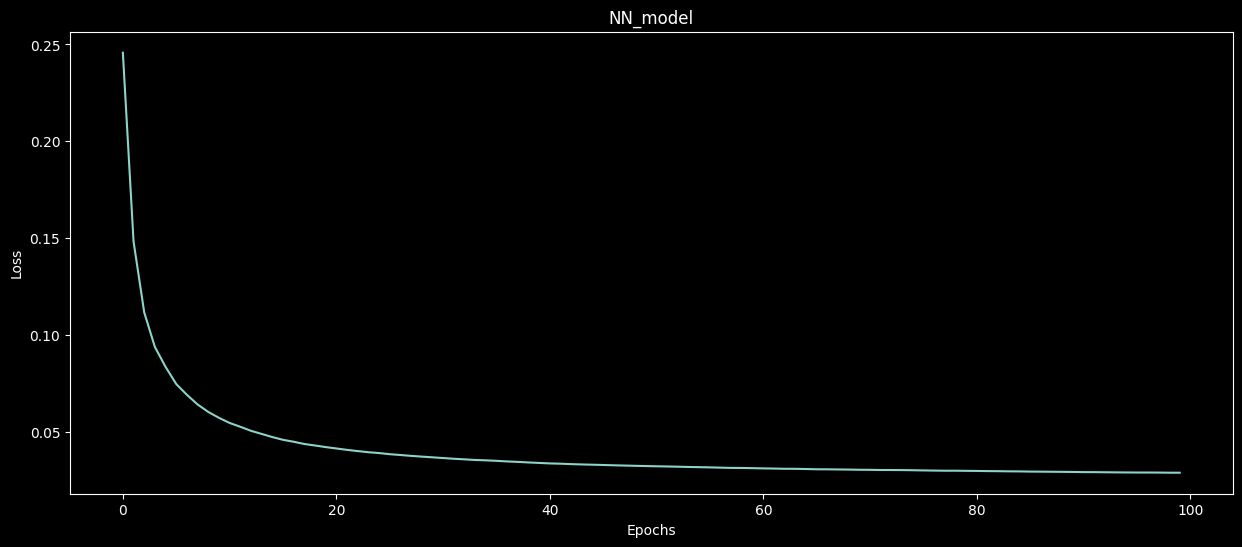

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle="-"
         )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("NN_model")
plt.show()

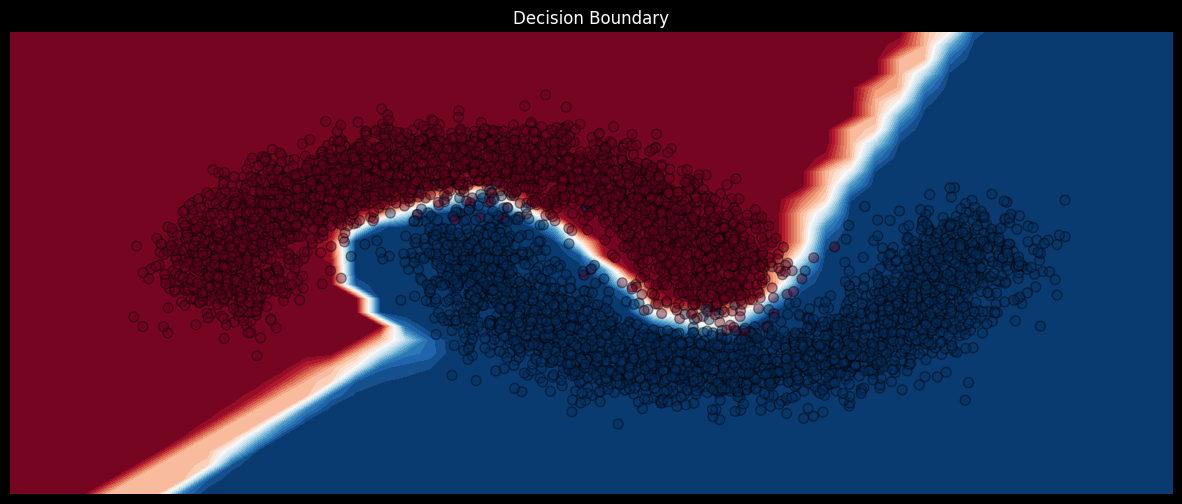

In [33]:
plot_decision_boundary(model.to("cpu"))

In [32]:
with torch.no_grad():
  torch.cuda.empty_cache()  #очистить ресурсы  GPU